In [130]:
#necessary Libraries
import numpy as np
import pandas as pd
import time
import pprint

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
# magic word for producing visualizations in notebook
%matplotlib inline

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA 
from scipy.sparse import lil_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Models
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#Scoring Metrics
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [143]:
# Load the dataset
file_path = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\ap_data_3.csv'
ap_data = pd.read_csv(file_path)

In [134]:
# Check the structure of the data after it's loaded 
#(print the number of rows and columns).
num_rows, num_cols  = ap_data.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

Number of columns: 9
Number of rows: 224


In [135]:
#check the statistics of the data per columns
ap_data.describe()

,channel,signal_strength,floorid,latitude,longitude
count,224.000000,224.000000,224.0,2.240000e+02,2.240000e+02
mean,2414.968750,-72.803571,101.0,7.065735e+00,1.255965e+02
std,3.847299,15.289341,0.0,3.738704e-14,6.551634e-13
min,2412.000000,-94.000000,101.0,7.065735e+00,1.255965e+02
25%,2412.000000,-89.000000,101.0,7.065735e+00,1.255965e+02
50%,2412.000000,-67.000000,101.0,7.065735e+00,1.255965e+02
75%,2417.000000,-60.000000,101.0,7.065735e+00,1.255965e+02
max,2427.000000,-50.000000,101.0,7.065735e+00,1.255965e+02


In [136]:
#Check the columns names
col_names = ap_data.columns.values
col_names

array(['mac_address', 'ssid', 'channel', 'source', 'signal_strength',
       'floorid', 'latitude', 'longitude', 'timestamp'], dtype=object)

In [137]:
#check for missing values
missing_values_count = ap_data.isnull().sum()
#uncomment this if you want to see the count of missing data per column
#missing_values_count

# how many total missing values do we have?
total_cells = np.product(ap_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
missing_percent = (total_missing/total_cells) * 100

print('Percent of missing data = {}%'.format(missing_percent))

Percent of missing data = 0.0%


In [138]:
#Assess unique values per columns
unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = ap_data["ssid"].unique()
unique_channel = ap_data["channel"].unique()
unique_floorid = ap_data["floorid"].unique()

print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel : {}'.format(unique_channel))
print('Unique Floor ID : {}'.format(unique_floorid))


Unique Mac Address : ['FE:47:AD:D7:13:E2' '13:E2']
Unique SSID : ['C1']
Unique Channel : [2417 2422 2412 2427]
Unique Floor ID : [101]


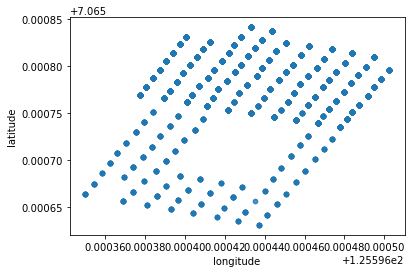

In [245]:
#Map the data i.e. see the campus
ap_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
plt.savefig('data_map.png')

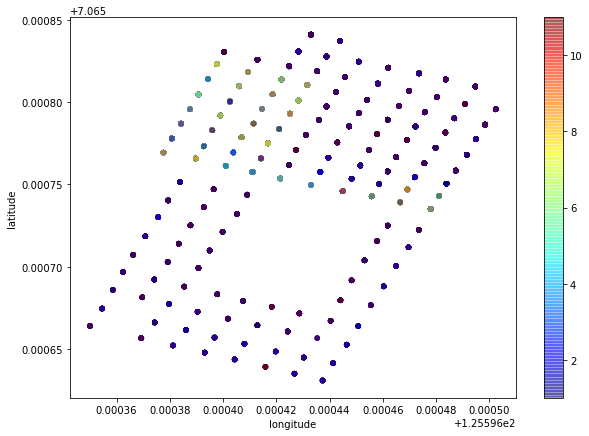

In [246]:
#map the data by user ID
#i.e. see how much of the information in each building was collected by how many users

# Assuming ap_data is your DataFrame
# Add a new column 'source_without_C' by removing 'C' from 'source'
ap_data['ssid'] = ap_data['ssid'].str.replace('C', '')

# Convert the 'source_without_C' column to numeric
ap_data['ssid'] = pd.to_numeric(ap_data['ssid'], errors='coerce')

# Plot the scatter plot using the modified 'source' values
ap_data.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    figsize=(10, 7),
    c=ap_data['ssid'],  # Use the modified 'source' values
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False
)

plt.savefig('user_map2.png')

<AxesSubplot:>

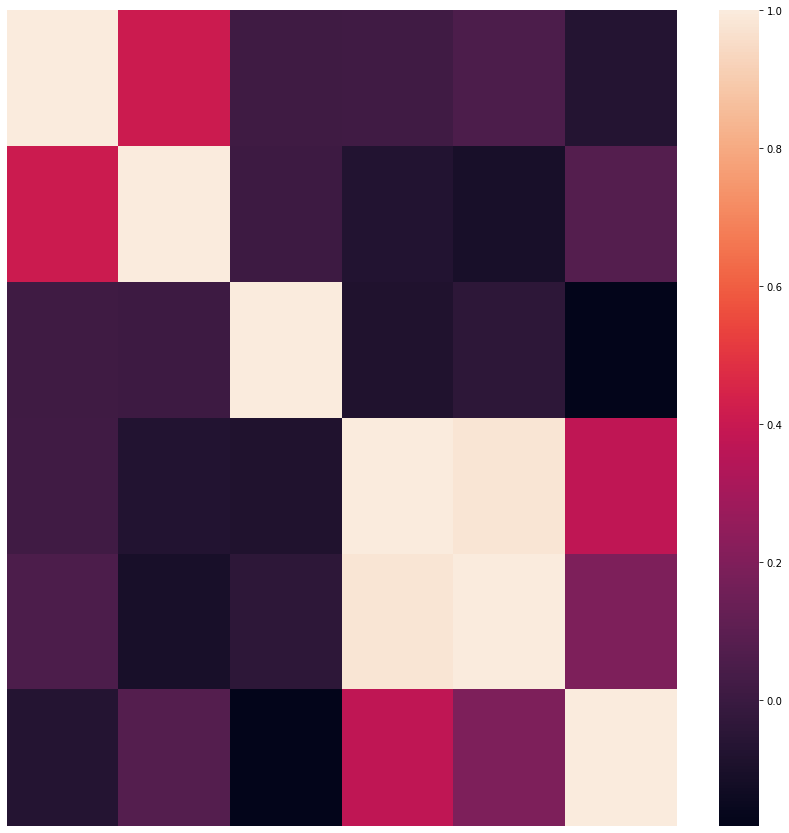

In [247]:
# plot the correlations between the WAP features
corr_matrix = ap_data.corr()
fig = plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix,xticklabels=False, yticklabels=False)

In [147]:
# Select relevant columns
selected_columns = ['source', 'channel', 'signal_strength', 'mac_address', 'ssid', 'timestamp', 'floorid', 'latitude', 'longitude']
ap_data_selected = ap_data[selected_columns]

# Pivot the DataFrame to create separate columns for each 'cap'
ap_data_pivot = ap_data_selected.pivot_table(
    index=['mac_address', 'ssid', 'timestamp', 'floorid', 'latitude', 'longitude'],
    columns='source',
    values=['channel', 'signal_strength'],
    aggfunc='first'
).reset_index()

# Flatten the MultiIndex columns
ap_data_pivot.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in ap_data_pivot.columns]


# Replace missing signal_strength values with 100
ap_data_pivot['signal_strength_cap1'].fillna(100, inplace=True)
ap_data_pivot['signal_strength_cap2'].fillna(100, inplace=True)
ap_data_pivot['signal_strength_cap3'].fillna(100, inplace=True)

# Replace missing channel values with 0
ap_data_pivot['channel_cap1'].fillna(0, inplace=True)
ap_data_pivot['channel_cap2'].fillna(0, inplace=True)
ap_data_pivot['channel_cap3'].fillna(0, inplace=True)


# Remove rows if there are two zeroes in a row in the cap_channel
ap_data_pivot = ap_data_pivot[
    ~((ap_data_pivot['channel_cap1'] == 0) & (ap_data_pivot['channel_cap2'] == 0)) &
    ~((ap_data_pivot['channel_cap2'] == 0) & (ap_data_pivot['channel_cap3'] == 0)) &
    ~((ap_data_pivot['channel_cap3'] == 0) & (ap_data_pivot['channel_cap3'] == 0))
]


# Save the DataFrame to a CSV file
ap_data_pivot.to_csv('ap_data_processed-3.csv', index=False)

# Print the resulting DataFrame
print(ap_data_pivot.head())


         mac_address ssid         timestamp  floorid  latitude   longitude  \
1  FE:47:AD:D7:13:E2   C1  24/11/2023 12:02      101  7.065735  125.596478   
2  FE:47:AD:D7:13:E2   C1  24/11/2023 12:03      101  7.065735  125.596478   
3  FE:47:AD:D7:13:E2   C1  24/11/2023 12:04      101  7.065735  125.596478   

   channel_cap1  channel_cap2  channel_cap3  signal_strength_cap1  \
1           0.0        2417.0        2412.0                 100.0   
2        2412.0        2417.0        2412.0                 -57.0   
3        2427.0        2417.0        2412.0                 -67.0   

   signal_strength_cap2  signal_strength_cap3  
1                 -66.0                 -89.0  
2                 -63.0                 -89.0  
3                 -66.0                 -93.0  


In [149]:
#Assess unique values per columns
unique_mac_address = ap_data_pivot["mac_address"].unique()
unique_ssid = ap_data_pivot["ssid"].unique()
unique_channel1 = ap_data_pivot["channel_cap1"].unique()
unique_channel2 = ap_data_pivot["channel_cap2"].unique()
unique_channel3 = ap_data_pivot["channel_cap3"].unique()
unique_floorid = ap_data_pivot["floorid"].unique()

print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel Cap1 : {}'.format(unique_channel1))
print('Unique Channel Cap2: {}'.format(unique_channel2))
print('Unique Channel Cap3: {}'.format(unique_channel3))
print('Unique Floor ID : {}'.format(unique_floorid))


Unique Mac Address : ['FE:47:AD:D7:13:E2']
Unique SSID : ['C1']
Unique Channel Cap1 : [   0. 2412. 2427.]
Unique Channel Cap2: [2417.]
Unique Channel Cap3: [2412.]
Unique Floor ID : [101]


In [140]:
# Load the dataset
ap_data_processed_data = r'C:\Users\pc\Desktop\Thesis\Untitled Folder 1\ap_data_processed-3.csv'
ap_data_processed = pd.read_csv(ap_data_processed_data)

In [141]:
print(len(ap_data_processed))

4


In [50]:
# Check the structure of the data after it's loaded 
#(print the number of rows and columns).
num_rows, num_cols  = ap_data_processed.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

Number of columns: 12
Number of rows: 2946


In [51]:
#Check the columns names
col_names = ap_data_processed.columns.values
col_names

array(['mac_address', 'ssid', 'timestamp', 'floorid', 'latitude',
       'longitude', 'cap1_channel', 'cap2_channel', 'cap3_channel',
       'cap1_signal_strength', 'cap2_signal_strength',
       'cap3_signal_strength'], dtype=object)

In [91]:
#Assess unique values per building columns
unique_mac_address = ap_data_processed["mac_address"].unique()
unique_ssid = ap_data_processed["ssid"].unique()
#unique_channel_cap1 = ap_data_processed["cap1_channel"].unique()
#unique_channel_cap2 = ap_data_processed["cap2_channel"].unique()
#unique_channel_cap3 = ap_data_processed["cap3_channel"].unique()
unique_floorid = ap_data_processed["floorid"].unique()

print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
#print('Unique Channel_cap1 : {}'.format(unique_channel_cap1))
#print('Unique Channel_cap2 : {}'.format(unique_channel_cap2))
#print('Unique Channel_cap3 : {}'.format(unique_channel_cap3))
print('Unique Floor ID : {}'.format(unique_floorid))


Unique Mac Address : ['02:9D:2F:8D:49:90' '1E:03:B6:E0:9E:3C' '22:95:8E:C1:1D:93'
 '52:39:94:90:76:D2' '56:3A:A2:F8:0C:63' '56:DE:9D:83:4D:C6'
 '6A:BD:12:5B:D6:64' '7A:44:1F:B5:90:E3' '7A:6B:C2:5A:7B:88'
 '8E:B0:7A:54:55:A6' 'A2:89:5E:B6:E7:58' 'B6:6A:AD:C1:CF:19'
 'BE:7E:CC:35:1C:46' 'E6:4C:39:FC:36:8B' 'F6:CE:87:F2:06:21'
 'FE:47:AD:D7:13:E2']
Unique SSID : ['C6' 'C2' 'C10' 'C3' 'C9' 'C11' 'C8' 'C7' 'C4' 'C5' 'C1']
Unique Floor ID : [101 102 103 104 105 106 107 108 109 110 111 112 117 118 119 120 127 128
 129 130 137 138 139 140 147 148 149 150 157 158 159 160 167 168 169 170
 187 188 189   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15
  16  17  18 113 114 115 116 121 122 123 124 125 126 131 132 133 134 135
 136 141 142 143 144 145 146 151 152 153 154 155 156 161 162 163 164 165
 166 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186]


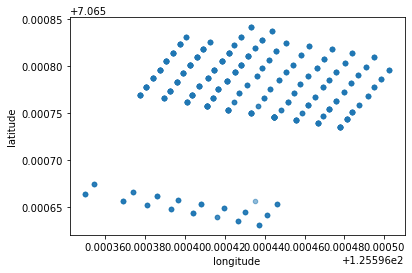

In [92]:
#Map the data i.e. see the campus
ap_data_processed.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
plt.savefig('data_map.png')

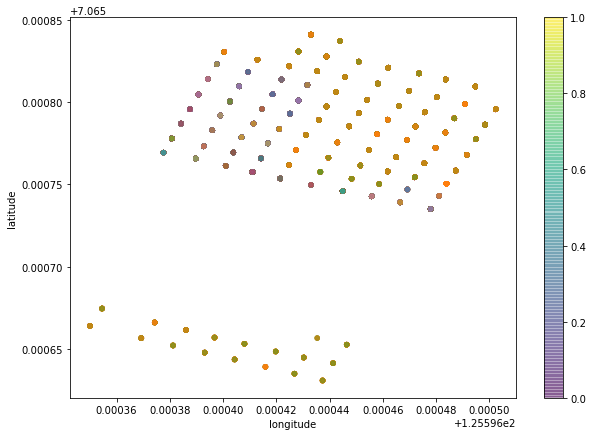

In [93]:
#map the data by user ID
#i.e. see how much of the information in each building was collected by how many users

# Assuming ap_data_processed is your DataFrame

# Plot the scatter plot using the modified 'source' values
ap_data.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    figsize=(10, 7),
    c=ap_data['ssid'],  # Use the modified 'source' values
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False
)

plt.savefig('user_map2.png')

<AxesSubplot:>

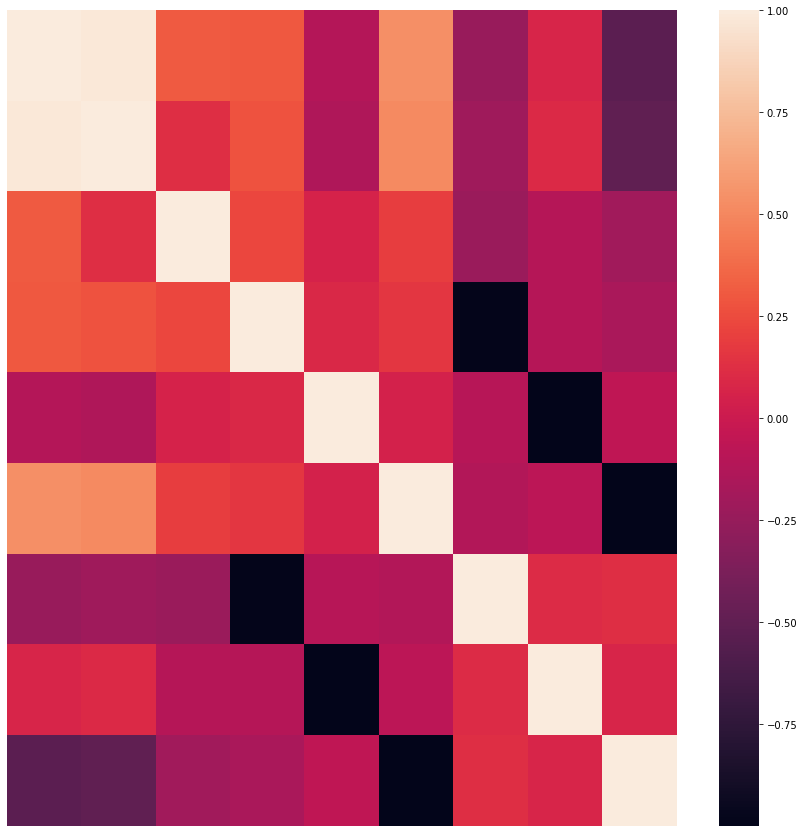

In [94]:
# plot the correlations between the WAP features
corr_matrix = ap_data_processed.corr()
fig = plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix,xticklabels=False, yticklabels=False)

In [95]:
#check the statistics of the data per columns
ap_data.describe()

,channel,signal_strength,floorid,latitude,longitude
count,12036.000000,12036.000000,12036.000000,12036.000000,12036.000000
mean,2433.777584,-70.246760,136.857345,7.065779,125.596436
std,17.210768,11.846509,39.630931,0.000040,0.000034
min,2412.000000,-104.000000,1.000000,7.065631,125.596350
25%,2417.000000,-79.000000,118.000000,7.065761,125.596408
50%,2437.000000,-70.000000,142.000000,7.065785,125.596435
75%,2447.000000,-61.000000,165.000000,7.065805,125.596465
max,2462.000000,-8.000000,189.000000,7.065841,125.596502


In [251]:
#check for missing values
missing_values_count = ap_data.isnull().sum()
#uncomment this if you want to see the count of missing data per column
#missing_values_count

# how many total missing values do we have?
total_cells = np.product(ap_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
missing_percent = (total_missing/total_cells) * 100

print('Percent of missing data = {}%'.format(missing_percent))

Percent of missing data = 0.3281325910528118%


In [ ]:
# plot the histograms of the attributes
ap_data.iloc[:, 1:9].hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [ ]:
# Load scanned data
scanned_data_cap1 = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\scanned_aps_cap1.csv'
scanned_data_cap2 = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\scanned_aps_cap2.csv'
scanned_data_cap3 = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\scanned_aps_cap3.csv'

data_cap1 = pd.read_csv(scanned_data_cap1)
data_cap2 = pd.read_csv(scanned_data_cap2)
data_cap3 = pd.read_csv(scanned_data_cap3)

In [ ]:
print(data_cap1)

# Check the structure of the data after it's loaded 
#(print the number of rows and columns).
num_rows, num_cols  = data_cap1.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

In [ ]:
print(data_cap2)

In [ ]:
print(data_cap3)

In [ ]:
print(type(data_cap1))
print(type(data_cap2))
print(type(data_cap3))


In [ ]:
  for 
        # Select relevant columns for each cap
        data_cap1_selected = data_cap1[['source', 'channel', 'signal_strength', 'mac_address', 'ssid']].head(i)
        data_cap2_selected = data_cap2[['source', 'channel', 'signal_strength', 'mac_address', 'ssid']].head(i)
        data_cap3_selected = data_cap3[['source', 'channel', 'signal_strength', 'mac_address', 'ssid']].head(i)

        # Combine data from all three caps based on MAC and SSID
        combined_scanned_data = pd.merge(data_cap1_selected, data_cap2_selected, on=['mac_address', 'ssid'])
        combined_scanned_data = pd.merge(combined_scanned_data, data_cap3_selected, on=['mac_address', 'ssid'])

        # Assign new column names based on the actual column names
        combined_scanned_data.columns = ['cap1', 'cap1_channel', 'cap1_signal_strength',
                                         'mac_address', 'ssid',
                                         'cap2', 'cap2_channel', 'cap2_signal_strength',
                                         'cap3', 'cap3_channel', 'cap3_signal_strength']

        # Rearrange columns to match the desired output
        desired_columns = ['cap1_signal_strength', 'cap2_signal_strength', 'cap3_signal_strength',
                           'cap1_channel', 'cap2_channel', 'cap3_channel',
                           'mac_address', 'ssid']
        combined_scanned_data = combined_scanned_data[desired_columns]

        print(combined_scanned_data)

In [ ]:
# Assuming 'data_cap1', 'data_cap2', and 'data_cap3' are your DataFrames for cap1, cap2, and cap3
# Replace these with the actual DataFrames in your code

# Get the maximum number of rows from the scanned data
max_rows = max(len(data_cap1), len(data_cap2), len(data_cap3))

# Initialize an empty DataFrame to store the combined data
combined_scanned_data = pd.DataFrame()

# Iterate through each column
for column in data_cap1.columns:  # Use the columns of any of the cap dataframes
    print(f"Processing column: {column}")

    # Select relevant columns for each cap
    data_cap1_selected = data_cap1[['source', 'channel', 'signal_strength', 'mac_address', 'ssid']].head(max_rows)
    data_cap2_selected = data_cap2[['source', 'channel', 'signal_strength', 'mac_address', 'ssid']].head(max_rows)
    data_cap3_selected = data_cap3[['source', 'channel', 'signal_strength', 'mac_address', 'ssid']].head(max_rows)

    # Combine data from all three caps based on MAC and SSID
    combined_data = pd.merge(data_cap1_selected, data_cap2_selected, on=['mac_address', 'ssid'], how='outer')
    combined_data = pd.merge(combined_data, data_cap3_selected, on=['mac_address', 'ssid'], how='outer')

    # Group by mac_address and ssid and fill NaN values with specified values
    combined_data = combined_data.groupby(['mac_address', 'ssid'], as_index=False).agg({
        'source': 'first',
        'channel': lambda x: x.fillna(0).astype(int).tolist(),
        'signal_strength': lambda x: x.fillna(100).astype(int).tolist()
    })

    # Append the combined data to the final DataFrame
    combined_scanned_data = pd.concat([combined_scanned_data, combined_data], axis=1)
    
    # Save the combined data to a CSV file
    output_file = 'combined_data.csv'
    combined_scanned_data.to_csv(output_file, index=False)

print(combined_scanned_data)

In [ ]:
num_elements = len(y_test)
k_nn = np.sqrt(num_elements)
print(k_nn)

In [ ]:
# Select relevant columns for each cap
data_cap1_selected = data_cap1[['source', 'channel', 'signal_strength', 'mac_address', 'ssid']].head(2)
data_cap2_selected = data_cap2[['source', 'channel', 'signal_strength', 'mac_address', 'ssid']].head(2)
data_cap3_selected = data_cap3[['source', 'channel', 'signal_strength', 'mac_address', 'ssid']].head(1)

# Combine data from all three caps based on MAC and SSID
combined_scanned_data = pd.merge(data_cap1_selected, data_cap2_selected, on=['mac_address', 'ssid'])

#print(combined_scanned_data)

combined_scanned_data = pd.merge(combined_scanned_data, data_cap3_selected, on=['mac_address', 'ssid'])

# Assign new column names based on the actual column names
combined_scanned_data.columns = ['cap1', 'cap1_channel', 'cap1_signal_strength',
                                 'mac_address', 'ssid',
                                 'cap2', 'cap2_channel', 'cap2_signal_strength',
                                 'cap3', 'cap3_channel', 'cap3_signal_strength']

# Rearrange columns to match the desired output
desired_columns = ['cap1_channel', 'cap2_channel', 'cap3_channel',
                   'cap1_signal_strength', 'cap2_signal_strength', 'cap3_signal_strength',
                   'mac_address', 'ssid']
combined_scanned_data = combined_scanned_data[desired_columns]

print(combined_scanned_data)

In [ ]:
ap_data_processed['ssid'] = ap_data_processed['ssid'].str.replace('C', '')

# Convert the 'source_without_C' column to numeric
ap_data_processed['ssid'] = pd.to_numeric(ap_data_processed['ssid'], errors='coerce')

print(ap_data_processed)



combined_scanned_data['ssid'] = combined_scanned_data['ssid'].str.replace('C', '')

# Convert the 'source_without_C' column to numeric
combined_scanned_data['ssid'] = pd.to_numeric(combined_scanned_data['ssid'], errors='coerce')

print(combined_scanned_data)

In [ ]:
def mac_to_numeric(mac_address):
    mac_octets = mac_address.split(':')
    numeric_value = int(''.join(mac_octets), 16)
    return numeric_value

ap_data_processed['mac_address'] = ap_data_processed['mac_address'].apply(mac_to_numeric)
combined_scanned_data['mac_address'] = combined_scanned_data['mac_address'].apply(mac_to_numeric)

In [ ]:
print(ap_data_processed)

print(combined_scanned_data)

In [ ]:
#Preprocess the Training Data Set //////////////////////////////////////////////////////////////////////////////////////////////

In [90]:
# Load the dataset
file_path = r'C:\Users\pc\Desktop\Thesis\Untitled Folder 1\ap_data_processed-2.csv'
trainingData = pd.read_csv(file_path)

print(trainingData)

            mac_address  ssid         timestamp  floorid  latitude  \
0     02:9D:2F:8D:49:90     6  10/11/2023 14:44      101  7.065735   
1     02:9D:2F:8D:49:90     6  10/11/2023 14:45      101  7.065735   
2     02:9D:2F:8D:49:90     6  10/11/2023 14:46      101  7.065735   
3     02:9D:2F:8D:49:90     6  10/11/2023 14:47      101  7.065735   
4     02:9D:2F:8D:49:90     6  10/11/2023 14:48      101  7.065735   
...                 ...   ...               ...      ...       ...   
2941  FE:47:AD:D7:13:E2     1  11/11/2023 11:03      121  7.065750   
2942  FE:47:AD:D7:13:E2     1  11/11/2023 11:04      121  7.065750   
2943  FE:47:AD:D7:13:E2     1  11/11/2023 11:05      121  7.065750   
2944  FE:47:AD:D7:13:E2     1  11/11/2023 11:06      121  7.065750   
2945  FE:47:AD:D7:13:E2     1  11/11/2023 11:07      121  7.065750   

       longitude  channel_cap1  channel_cap2  channel_cap3  \
0     125.596478        2417.0        2417.0        2412.0   
1     125.596478        2417.0     

In [91]:
trainingData.describe()

,ssid,floorid,latitude,longitude,channel_cap1,channel_cap2,channel_cap3,signal_strength_cap1,signal_strength_cap2,signal_strength_cap3
count,2946.000000,2946.000000,2946.000000,2946.000000,2946.000000,2946.000000,2946.000000,2946.000000,2946.000000,2946.000000
mean,4.914800,115.075017,7.065760,125.596428,2045.277665,2122.107604,1165.464019,-37.916836,-48.024440,10.695180
std,3.885003,52.405525,0.000051,0.000035,893.642155,815.703791,1215.859511,60.994081,57.427495,93.232423
min,1.000000,1.000000,7.065631,125.596350,0.000000,0.000000,0.000000,-96.000000,-96.000000,-102.000000
25%,2.000000,101.000000,7.065739,125.596400,2412.000000,2412.000000,0.000000,-69.000000,-75.000000,-87.000000
50%,3.000000,126.000000,7.065771,125.596425,2432.000000,2432.000000,0.000000,-60.000000,-70.000000,100.000000
75%,8.750000,157.000000,7.065798,125.596456,2447.000000,2447.000000,2437.000000,-53.000000,-61.000000,100.000000
max,11.000000,189.000000,7.065841,125.596502,2462.000000,2462.000000,2462.000000,100.000000,100.000000,100.000000


In [92]:
def clean_data(df):
    """
    Perform feature trimming, and engineering for trainingData
    Will also be applied to validationData
    
    INPUT: trainingData DataFrame
    OUTPUT: Trimmed and cleaned trainingData DataFrame
    """
    
    # Reverse the representation for the values. 100=0 and teh values range from 0-105 (weakest to strongest)
    #"The intensity values are represented as negative integer values ranging -104dBm (extremely poor signal) to 0dbM.
    #The positive value 100 is used to denote when a WAP was not detected."
    df.iloc[:, 9:12] = np.where(df.iloc[:, 9:12] <= 0, 
                df.iloc[:, 9:12] + 105, 
                df.iloc[:, 9:12] - 100)
    
    '''
    df.iloc[:, 6:9] = np.where(df.iloc[:, 6:9] > 2000, 
                df.iloc[:, 6:9] - 2300, 
                df.iloc[:, 6:9] - 0)
    '''
    
    # remove selected columns... 
    columns_removed = ['mac_address','timestamp']
    for col in columns_removed:
        df.drop(col, axis=1, inplace=True)
    
   
    # Return the cleaned dataframe.
    return df 

In [93]:
#Apply Cleaning

trainingData  = clean_data(trainingData)

print(trainingData)
#trainingData.to_csv('trainingData.csv', index=False)

      ssid  floorid  latitude   longitude  channel_cap1  channel_cap2  \
0        6      101  7.065735  125.596478        2417.0        2417.0   
1        6      101  7.065735  125.596478        2417.0        2412.0   
2        6      101  7.065735  125.596478        2417.0        2412.0   
3        6      101  7.065735  125.596478        2422.0        2422.0   
4        6      101  7.065735  125.596478        2422.0        2412.0   
...    ...      ...       ...         ...           ...           ...   
2941     1      121  7.065750  125.596484        2417.0        2417.0   
2942     1      121  7.065750  125.596484        2417.0        2417.0   
2943     1      121  7.065750  125.596484        2422.0        2417.0   
2944     1      121  7.065750  125.596484        2417.0        2417.0   
2945     1      121  7.065750  125.596484        2417.0        2412.0   

      channel_cap3  signal_strength_cap1  signal_strength_cap2  \
0           2412.0                  48.0                 

In [119]:
import pandas as pd

def preprocess_data(df):
    """
    Separates trainingData into Features and Targets
    Will also be applied to validationData
    
    INPUT: Cleaned trainingData DataFrame
    OUTPUT: trainingData as Features and Targets
    """
    # split the data set into features and targets(Floor and BuildingID)
    X = df.drop(['longitude', 'latitude', 'floorid'], axis=1)
    y = df[['floorid']]
    
    # Extract unique channel values
    unique_channels = sorted(set(df['channel_cap1'].unique()) | set(df['channel_cap2'].unique()) | set(df['channel_cap3'].unique()))
    
    # Create new one-hot encoded columns
    for channel in unique_channels:
        X[f'channel_cap1_{channel}'] = (df['channel_cap1'] == channel).astype(int)
        X[f'channel_cap2_{channel}'] = (df['channel_cap2'] == channel).astype(int)
        X[f'channel_cap3_{channel}'] = (df['channel_cap3'] == channel).astype(int)
    
    # Drop the original 'channel_cap1', 'channel_cap2', and 'channel_cap3' columns
    X.drop(['channel_cap1', 'channel_cap2', 'channel_cap3'], axis=1, inplace=True)
    
    # Iterate over signal strength caps and channels to perform multiplication
    signal_columns = ['signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3']
    
    for signal_col in signal_columns:
        for channel in unique_channels:
            channel_col1 = f'channel_cap1_{channel}'
            channel_col2 = f'channel_cap2_{channel}'
            channel_col3 = f'channel_cap3_{channel}'
            
            if signal_col.endswith('cap1'):
                X[f'{signal_col}_{channel_col1}'] = df[signal_col] * X[channel_col1]
            elif signal_col.endswith('cap2'):
                X[f'{signal_col}_{channel_col2}'] = df[signal_col] * X[channel_col2]
            elif signal_col.endswith('cap3'):
                X[f'{signal_col}_{channel_col3}'] = df[signal_col] * X[channel_col3]

    # Drop the original 'signal_strength' columns
    X.drop(['signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3'], axis=1, inplace=True)
    
    # Drop unwanted columns
    unwanted_columns = [f'channel_cap{i}_{cap}' for i in range(1, 4) for cap in unique_channels]
    X.drop(unwanted_columns, axis=1, inplace=True)
    
    # create Dummies for the targets to feed into the model
    y = pd.get_dummies(data=y, columns=['floorid'])
    
    return X, y


In [120]:
#Apply preprocessing

X, y = preprocess_data(trainingData)


#y.to_csv('y_values.csv', index=False)

In [121]:
print(X)


# Replace 'output_file.csv' with the desired file name
output_file = 'preprocessed_data.csv'

# Save the DataFrame to a CSV file
X.to_csv(output_file, index=False)


      ssid  signal_strength_cap1_channel_cap1_0.0  \
0        6                                    0.0   
1        6                                    0.0   
2        6                                    0.0   
3        6                                    0.0   
4        6                                    0.0   
...    ...                                    ...   
2941     1                                    0.0   
2942     1                                    0.0   
2943     1                                    0.0   
2944     1                                    0.0   
2945     1                                    0.0   

      signal_strength_cap1_channel_cap1_2412.0  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
2941         

In [122]:
print(y)


      floorid_1  floorid_2  floorid_3  floorid_4  floorid_5  floorid_6  \
0             0          0          0          0          0          0   
1             0          0          0          0          0          0   
2             0          0          0          0          0          0   
3             0          0          0          0          0          0   
4             0          0          0          0          0          0   
...         ...        ...        ...        ...        ...        ...   
2941          0          0          0          0          0          0   
2942          0          0          0          0          0          0   
2943          0          0          0          0          0          0   
2944          0          0          0          0          0          0   
2945          0          0          0          0          0          0   

      floorid_7  floorid_8  floorid_9  floorid_10  ...  floorid_180  \
0             0          0          0   

In [127]:
def split_data(preprocess_data):
# TO AVOID OVERFITTING: Split the training data into training and testing sets 
    global X_train
    global X_test
    global y_train
    global y_test
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.2, 
                                                        random_state = 42,
                                                        shuffle=True)

    # Show the results of the split
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [128]:
#Apply split data

X_train, X_test, y_train, y_test = split_data(preprocess_data)



Training set has 2356 samples.
Testing set has 590 samples.


In [129]:
#Scale Data with Standard Scaler

scaler = StandardScaler()

#Fit only the training set
#this will help us transform the validation data 
scaler.fit(X_train)
    
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

k = 1  # You can adjust the value of k
knn = KNeighborsClassifier(n_neighbors=k, p=2, metric = 'euclidean')  # p=2 for Euclidean metric
knn.fit(X_train, y_train)

# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 9.32%


In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

k = 1  # You can adjust the value of k
knn = KNeighborsClassifier(n_neighbors=k, p=2, metric = 'euclidean')  # p=2 for Euclidean metric
knn.fit(X_train, y_train)

# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 10.85%


In [117]:
#Apply PCA while keeping 95% of the variation in the data
pca = PCA(.95)

    
#Fit only the training set    
pca.fit(X_train)

# Apply PCA transform to both the training set and the test set.    
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of PCA Components = {}.".format(pca.n_components_))
#print(pca.n_components_)
print("Total Variance Explained by PCA Components = {}.".format(pca.explained_variance_ratio_.sum()))
#print(pca.explained_variance_ratio_.sum())

Number of PCA Components = 5.
Total Variance Explained by PCA Components = 0.9864277799569328.


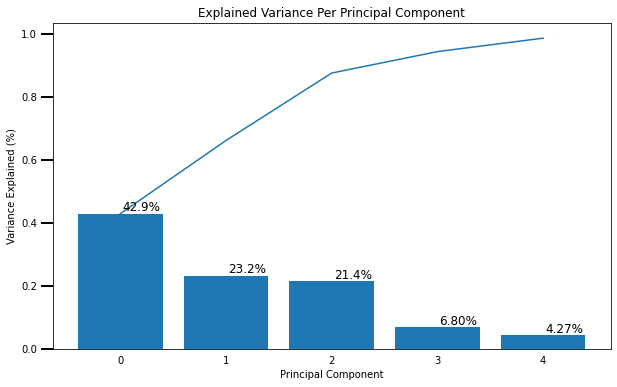

In [118]:
def pca_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

pca_plot(pca)

In [119]:
#Create sparse matrices to run the scikit multilearn algorithms

X_train_pca = lil_matrix(X_train_pca).toarray()
y_train = lil_matrix(y_train).toarray()
X_test_pca = lil_matrix(X_test_pca).toarray()
y_test = lil_matrix(y_test).toarray()

In [120]:
#MODEL Model Applications////////////////////////////////////////////////////////////////////////////////////////////////////////

In [121]:
# using binary relevance
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

BR_classifier = BinaryRelevance(GaussianNB())
# train
BR_classifier.fit(X_train, y_train)
# predict
predictions = BR_classifier.predict(X_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))


Accuracy =  0.0
--- Run time: 0.0 mins ---


In [122]:
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

CC_classifier = ClassifierChain(GaussianNB())

# train
CC_classifier.fit(X_train, y_train)

# predict
predictions = CC_classifier.predict(X_test)

accuracy_score(y_test,predictions)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictions)))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Test accuracy is 0.006437768240343348
--- Run time: 0.01 mins ---


In [123]:
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

LP_classifier = LabelPowerset(GaussianNB())

# train
LP_classifier.fit(X_train, y_train)

# predict
predictions = LP_classifier.predict(X_test)

accuracy_score(y_test,predictions)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictions)))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Test accuracy is 0.03862660944206009
--- Run time: 0.0 mins ---


In [124]:
start_time = time.time()

MLKNN_classifier = MLkNN(k=1)

# train
MLKNN_classifier.fit(X_train_pca, y_train)

# predict mlknn =3
predictions = MLKNN_classifier.predict(X_test_pca)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Accuracy =  0.07081545064377683
--- Run time: 0.17 mins ---


In [109]:
#This is takes a long time to run
#Find the optimal set of parameters

start_time = time.time()

parameters = {'k': range(1,50), 's': [0.5, 0.7, 1.0]}

score = 'accuracy'


clf = GridSearchCV(MLkNN(), parameters, scoring=score, cv=5)
clf.fit(X_train_pca, y_train)

print (clf.best_params_, clf.best_score_)
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


KeyboardInterrupt: 

In [150]:
#Apply PCA while keeping 95% of the variation in the data
pca = PCA(.95)

    
#Fit only the training set    
pca.fit(X_train)

# Apply PCA transform to both the training set and the test set.    
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of PCA Components = {}.".format(pca.n_components_))
#print(pca.n_components_)
print("Total Variance Explained by PCA Components = {}.".format(pca.explained_variance_ratio_.sum()))
#print(pca.explained_variance_ratio_.sum())

Number of PCA Components = 28.
Total Variance Explained by PCA Components = 0.9517089080842009.


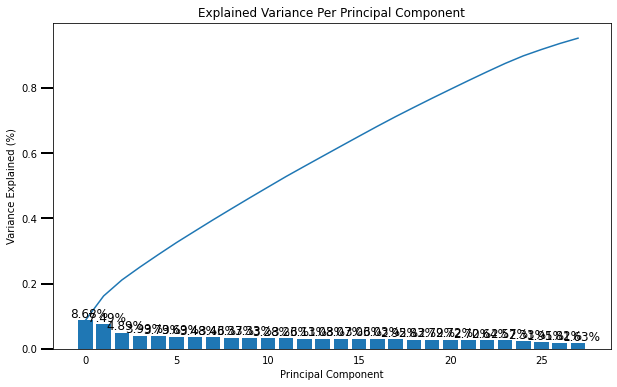

In [151]:
def pca_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca_plot(pca)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

k = 1  # You can adjust the value of k
knn = KNeighborsClassifier(n_neighbors=k, p=2, metric = 'euclidean')  # p=2 for Euclidean metric
knn.fit(X_train, y_train)

# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 8.64%


In [ ]:
# Assuming 'ap_data_processed' is your training data DataFrame
# Replace these column names with the actual column names in your dataset
features = ['ssid','cap1_signal_strength', 'cap2_signal_strength', 'cap3_signal_strength',
            'cap1_channel', 'cap2_channel', 'cap3_channel']
target = 'floorid'

# Select features (X) and target variable (y)
X = ap_data_processed[features]
y = ap_data_processed[target]



In [ ]:
def split_data(preprocess_data):
# TO AVOID OVERFITTING: Split the training data into training and testing sets 
    global X_train
    global X_test
    global y_train
    global y_test
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.2, 
                                                        random_state = 42,
                                                        shuffle=True)

    # Show the results of the split
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [ ]:
# Assuming 'combined_scanned_data' is your scanned data DataFrame

# Assuming 'ap_data_processed' is your training data DataFrame
# Replace these column names with the actual column names in your dataset
features = ['ssid','cap1_signal_strength', 'cap2_signal_strength', 'cap3_signal_strength',
            'cap1_channel', 'cap2_channel', 'cap3_channel']
target = 'floorid'

# Select features (X) and target variable (y)
X = ap_data_processed[features]
y = ap_data_processed[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=42)

# Train a k-Nearest Neighbors classifier with Euclidean metric
k = 1 # You can adjust the value of k
knn = KNeighborsClassifier(n_neighbors=k, p=2, metric = 'euclidean')  # p=2 for Euclidean metric
knn.fit(X_train, y_train)

# Assuming 'combined_scanned_data' is your scanned data DataFrame
# Replace these column names with the actual column names in your dataset
scanned_data_features = combined_scanned_data[features]

# Make predictions on the scanned data
predictions = knn.predict(scanned_data_features)

# Add predicted floorid to the scanned data
combined_scanned_data['predicted_floorid'] = predictions

# Display the predicted floorid for the scanned data
print(combined_scanned_data[['mac_address', 'ssid', 'predicted_floorid']])

In [ ]:
# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

start_time = time.time()

parameters = {'n_neighbors': range(1, 500), 'p': [2], 'metric': ['euclidean']}
score = 'accuracy'

knn = GridSearchCV(KNeighborsClassifier(), parameters, scoring=score, cv=3)
knn.fit(X_train, y_train)

print(knn.best_params_, knn.best_score_)
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time) / 60), 2))


In [ ]:
#Apply PCA while keeping 95% of the variation in the data
pca = PCA(.95)

    
#Fit only the training set    
pca.fit(X_train)

# Apply PCA transform to both the training set and the test set.    
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of PCA Components = {}.".format(pca.n_components_))
#print(pca.n_components_)
print("Total Variance Explained by PCA Components = {}.".format(pca.explained_variance_ratio_.sum()))
#print(pca.explained_variance_ratio_.sum())

In [ ]:
def pca_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca_plot(pca)

In [ ]:
#Create sparse matrices to run the scikit multilearn algorithms

X_train_pca = lil_matrix(X_train_pca).toarray()
y_train = lil_matrix(y_train).toarray()
X_test_pca = lil_matrix(X_test_pca).toarray()
y_test = lil_matrix(y_test).toarray()



print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of y_train_lil:", y_train_lil.shape)


In [ ]:
print("Shape of X_train_pca:", X_train_pca.shape)


In [ ]:
# Check column names
print(X_train_pca.columns)

In [ ]:
# Access a specific column by index
print(X_train_pca.iloc[:, 148])

In [ ]:
print("Shape of y_train:", y_train.shape)

In [ ]:
import numpy as np

# Check the shape of X_train_pca
print("Shape of X_train_pca:", X_train_pca.shape)

# Access a specific column by index (for example, column at index 148)
column_2 = X_train_pca[:, 2]
print("Column at index 2:", column_2)

# If you want to check all column values, you can loop through columns
for i in range(X_train_pca.shape[1]):
    print(f"Column {i}:", X_train_pca[:, i])

In [ ]:
print("Column indices:", range(X_train_pca.shape[1]))


In [ ]:
print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of y_train_lil:", y_train_lil.shape)


In [ ]:
start_time = time.time()

from skmultilearn.adapt import MLkNN
from scipy.sparse import lil_matrix

# Convert y_train to sparse format
y_train_lil = lil_matrix(y_train.T)  # Transpose y_train if necessary

# Create and fit the MLkNN model
MLKNN_1_classifier = MLkNN(k=1)
MLKNN_1_classifier.fit(X_train_pca, y_train_lil)

# Run predictions
predictions = MLKNN_1_classifier.predict(X_test_pca)

# Accuracy
print("Accuracy =", accuracy_score(y_test, predictions))



print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

In [ ]:
print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of y_train:", y_train.shape)


In [ ]:
y_train = y_train.T  # Transpose y_train


In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN classifier with scaled data
knn.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred_scaled = knn.predict(X_test_scaled)

# Calculate accuracy
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)

print(f'Accuracy with scaled features: {accuracy_scaled * 100:.2f}%')


In [ ]:
#Extract data to the database
import sqlite3
import pandas as pd

# Connect to your SQLite database (replace 'your_database.db' with the actual database file)
conn = sqlite3.connect('rfid_ips.db')

# Replace 'your_query' with the SQL query to select the data you want
your_query = "SELECT * FROM ap_data_position"

# Use pandas to read the query result into a DataFrame
df = pd.read_sql_query(your_query, conn)

# Replace 'output_file.csv' with the desired file name
output_file = 'ap_data_position.csv'

# Save the DataFrame to a CSV file
df.to_csv(output_file, index=False)

print(f"Data extracted and saved to {output_file}")

# Select relevant columns
selected_columns = ['source', 'channel', 'signal_strength', 'mac_address', 'ssid', 'timestamp']
ap_data_selected = ap_data_position[selected_columns]

# Pivot the DataFrame to create separate columns for each 'cap'
ap_data_pivot = ap_data_selected.pivot_table(
    index=['mac_address', 'ssid', 'timestamp'],
    columns='source',
    values=['channel', 'signal_strength'],
    aggfunc='first'
).reset_index()

# Flatten the MultiIndex columns
ap_data_pivot.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in ap_data_pivot.columns]

# Rename columns for clarity
ap_data_pivot.columns = [
    'mac_address', 'ssid', 'timestamp',
    'cap1_channel', 'cap2_channel', 'cap3_channel',
    'cap1_signal_strength', 'cap2_signal_strength', 'cap3_signal_strength'
]

# Replace missing signal_strength values with 100
ap_data_pivot['cap1_signal_strength'].fillna(100, inplace=True)
ap_data_pivot['cap2_signal_strength'].fillna(100, inplace=True)
ap_data_pivot['cap3_signal_strength'].fillna(100, inplace=True)

# Replace missing channel values with 0
ap_data_pivot['cap1_channel'].fillna(0, inplace=True)
ap_data_pivot['cap2_channel'].fillna(0, inplace=True)
ap_data_pivot['cap3_channel'].fillna(0, inplace=True)

# Save the DataFrame to a CSV file
ap_data_pivot.to_csv('ap_data_position_processed.csv', index=False)

# Print the resulting DataFrame
print(ap_data_pivot.head())

#If CAP1, CAP2, and CAP3 are available
# Check if the CSV file exists
if os.path.exists(csv_file):
    # Read the CSV file into a DataFrame
    ap_data_pivot = pd.read_csv(csv_file)

    # Check if 'cap1', 'cap2', and 'cap3' are available in the 'source' column
    if all(cap in ap_data_pivot['source'].unique() for cap in ['cap1', 'cap2', 'cap3']):
        # Select relevant columns for training the KNN algorithm
        features = ['cap1_signal_strength', 'cap2_signal_strength', 'cap3_signal_strength',
                    'cap1_channel', 'cap2_channel', 'cap3_channel']
        target = 'floorid'  # Replace with the actual target variable

        # Assuming 'ap_data_pivot' is your DataFrame
        X = ap_data_pivot[features]
        y = ap_data_pivot[target]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train a k-Nearest Neighbors classifier
        k = 23  # You can adjust the value of k
        knn = KNeighborsClassifier(n_neighbors=k, p=2)  # p=2 for Euclidean metric
        knn.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = knn.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        print(f'Accuracy: {accuracy * 100:.2f}%')

        # Now you can proceed with further processing after the KNN algorithm

        # After processing, delete the CSV file
        os.remove(csv_file)
        print(f"CSV file '{csv_file}' deleted.")
    else:
        print("Missing 'cap1', 'cap2', or 'cap3' in the 'source' column.")
else:
    print(f"CSV file '{csv_file}' not found.")


In [ ]:
# Load scanned data
combined_scanned = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\ap_data_position_processed_before - Copy.csv'

data_cap = pd.read_csv(combined_scanned)

In [ ]:
print(data_cap)

In [ ]:
dataset = pd.read_csv('ap_data_processed.csv')

In [ ]:
num_elements = len(dataset)
k_nn = np.sqrt(num_elements)
print(k_nn)

In [ ]:
# Assuming 'ap_data_processed' is your training data DataFrame
# Replace these column names with the actual column names in your dataset
features = ['ssid','cap1_channel', 'cap2_channel', 'cap3_channel',
            'cap1_signal_strength', 'cap2_signal_strength', 'cap3_signal_strength']
target = 'floorid'

# Select features (X) and target variable (y)
X = ap_data_processed[features]
y = ap_data_processed[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42) #42

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Train a k-Nearest Neighbors classifier with Euclidean metric
k = 23 # You can adjust the value of k, 17 = 8.18%, 45 = 8.38%, 51 = 8.59%, 67=8.79%, 23=8.79%
knn = KNeighborsClassifier(n_neighbors=k, p=2, metric = 'euclidean')  # p=2 for Euclidean metric
knn.fit(X_train, y_train)

# Assuming 'combined_scanned_data' is your scanned data DataFrame
# Replace these column names with the actual column names in your dataset
scanned_data_features = data_cap[features]

# Make predictions on the scanned data
predictions = knn.predict(scanned_data_features)

# Add predicted floorid to the scanned data
data_cap['predicted_floorid'] = predictions

# Display the predicted floorid for the scanned data
print(data_cap[['mac_address', 'ssid', 'predicted_floorid']])

In [ ]:
# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
# Assuming 'ap_data_processed' is your training data DataFrame
# Replace these column names with the actual column names in your dataset
features = ['cap1_channel', 'cap2_channel', 'cap3_channel',
            'cap1_signal_strength', 'cap2_signal_strength', 'cap3_signal_strength']
target = 'floorid'

# Select features (X) and target variable (y)
X = ap_data_processed[features]
y = ap_data_processed[target]

# No need to split the data into training and testing sets for prediction

#sc_X = StandardScaler()
#X = sc_X.fit_transform(X)  # You can fit_transform the entire X as you're not splitting

# Train a k-Nearest Neighbors classifier with Euclidean metric
k = 17  # You can adjust the value of k
knn = KNeighborsClassifier(n_neighbors=k, p=2)  # p=2 for Euclidean metric
knn.fit(X, y)

# Assuming 'data_cap' is your scanned data DataFrame
# Replace these column names with the actual column names in your dataset
scanned_data_features = data_cap[features]

# Make predictions on the scanned data
predictions = knn.predict(scanned_data_features)

# Add predicted floorid to the scanned data
data_cap['predicted_floorid'] = predictions

# Display the predicted floorid for the scanned data
print(data_cap[['mac_address', 'ssid', 'predicted_floorid']])


In [ ]:
# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
# Load the dataset
file_path = r'C:\Users\Thesis2.0\django_thesis\Dataset\diabetes.csv'
DATASET = pd.read_csv(file_path)

In [ ]:
# Assuming 'ap_data_processed' is your training data DataFrame
# Replace these column names with the actual column names in your dataset
features = ['Pregnancies', 'Glucose', 'BloodPressure',
            'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
# Pregnancies	Glucose	BloodPressure	SkinThickness	Insulin	BMI	DiabetesPedigreeFunction	Age
target = 'Outcome'

# Select features (X) and target variable (y)
X = DATASET[features]
y = DATASET[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_) #42

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Train a k-Nearest Neighbors classifier with Euclidean metric
k = 1 # You can adjust the value of k
knn = KNeighborsClassifier(n_neighbors=k, p=2)  # p=2 for Euclidean metric
knn.fit(X_train, y_train)

# Assuming 'combined_scanned_data' is your scanned data DataFrame
# Replace these column names with the actual column names in your dataset
scanned_data_features = DATASET[features]

# Make predictions on the scanned data
predictions = knn.predict(scanned_data_features)

# Add predicted floorid to the scanned data
DATASET['predicted'] = predictions

# Display the predicted floorid for the scanned data
print(dataset[['mac_address', 'ssid', 'DATASET']])

In [ ]:
# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')